In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import fresnel
import scipy.constants as cnst
from sympy import *
from sympy.physics.quantum import TensorProduct
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
init_printing()

%matplotlib notebook


x, y, z =symbols('x y z', real=True)
theta = Symbol('theta',real=True)
phi = Symbol('phi',real=True)
T, kB, h, Omega = symbols('T k h Omega', real=True)

This is going to be another symbolic calculation, but we are going to use Liouville space operators and superoperators instead. The basis for a single density operator is $S_x, S_y, S_z, \frac12 I$, so for the double it will be a tensor product for maximal simplicity.

We will be constructing rotation superoperators. In Hilbert space, the effect of a rotation of density matrix over the operator $\hat{B}$ and angle $\phi$ is $\exp{(- \hat{B} \phi)} \hat{\rho} \exp{(\hat{B} \phi)}$. Because $\hat{B}$ is based on Pauli matrices, it can be shown that 
$$\exp{(- \hat{B} \phi)} = \cos (\frac{\phi}2) I -2 i \sin(\frac{\phi}2) \hat{B}$$
So it follows that 
$$\exp{(- \hat{B} \phi)} \hat{\rho} \exp{(\hat{B} \phi)} = (\cos (\frac{\phi}2) I -2 i \sin(\frac{\phi}2) \hat{B})\hat{\rho}(\cos (\frac{\phi}2) I +2 i \sin(\frac{\phi}2) \hat{B})$$



In [2]:
#First define matrices for single spin, to then use the tensor product 
#They are funny because there is an additional factor of 1/2 which makes it more complicated,
#I am going to allow it to be consistent

LSX = Rational(1,2)*Matrix([
    [0,0,0,1],
    [0,0,-I,0],
    [0,I,0,0],
    [1,0,0,0]
])

LSY = Rational(1,2)*Matrix([
    [0,0,I,0],
    [0,0,0,1],
    [-I,0,0,0],
    [0,1,0,0]
])

LSZ = Rational(1,2)*Matrix([
    [0,-I,0,0],
    [I,0,0,0],
    [0,0,0,1],
    [0,0,1,0]
])

RSX = Rational(1,2)*Matrix([
    [0,0,0,1],
    [0,0,I,0],
    [0,-I,0,0],
    [1,0,0,0]
])

RSY = Rational(1,2)*Matrix([
    [0,0,-I,0],
    [0,0,0,1],
    [I,0,0,0],
    [0,1,0,0]
])

RSZ = Rational(1,2)*Matrix([
    [0,I,0,0],
    [-I,0,0,0],
    [0,0,0,1],
    [0,0,1,0]
])



In [3]:
#Define matrices in Hilbert space so we can change bases and calculate purity and entanglement of density operators

sigma_x = Matrix([
    [0,1],
    [1,0]
])

sigma_y = Matrix([
    [0,-I],
    [I,0]
])

sigma_z = Matrix([
    [1,0],
    [0,-1]
])

sigma_3 = eye(2)

In [4]:
def prod_op_to_hilbert(rho):
    """ 
    Takes a 16 entry vector in the basis 2Sx1Sx2, 2Sx1Sy2, 2Sx1Sz1,Sx1,...,2Sz1Sy2,2Sz1Sz2,Sx2,Sz2,Sy2, 1/2 I
    Produces an appropriate 4x4 density matrix
    """
    
    new_rho = Matrix(zeros(4,4))
    
    new_rho = new_rho + rho[0]*TensorProduct(sigma_x,sigma_x)
    new_rho = new_rho + rho[1]*TensorProduct(sigma_x,sigma_y)
    new_rho = new_rho + rho[2]*TensorProduct(sigma_x,sigma_z)
    new_rho = new_rho + rho[3]*TensorProduct(sigma_x,sigma_3)
    new_rho = new_rho + rho[4]*TensorProduct(sigma_y,sigma_x)
    new_rho = new_rho + rho[5]*TensorProduct(sigma_y,sigma_y)
    new_rho = new_rho + rho[6]*TensorProduct(sigma_y,sigma_z)
    new_rho = new_rho + rho[7]*TensorProduct(sigma_y,sigma_3)
    new_rho = new_rho + rho[8]*TensorProduct(sigma_z,sigma_x)
    new_rho = new_rho + rho[9]*TensorProduct(sigma_z,sigma_y)
    new_rho = new_rho + rho[10]*TensorProduct(sigma_z,sigma_z)
    new_rho = new_rho + rho[11]*TensorProduct(sigma_z,sigma_3)
    new_rho = new_rho + rho[12]*TensorProduct(sigma_3,sigma_x)
    new_rho = new_rho + rho[13]*TensorProduct(sigma_3,sigma_y)
    new_rho = new_rho + rho[14]*TensorProduct(sigma_3,sigma_z)
    new_rho = new_rho + rho[15]*eye(4)
    
    return Rational(1,4)*new_rho

In [5]:
def hilbert_to_prod_op(rho):
    """
    Takes a 4x4 density matrix and produces a 16 entry density vector in product operator basis
    """
    
    new_rho = Matrix(zeros(16,1))

    new_rho[0] = simplify(trace(rho*TensorProduct(sigma_x,sigma_x)))
    new_rho[1] = simplify(trace(rho*TensorProduct(sigma_x,sigma_y)))
    new_rho[2] = simplify(trace(rho*TensorProduct(sigma_x,sigma_z)))
    new_rho[3] = simplify(trace(rho*TensorProduct(sigma_x,sigma_3)))
    new_rho[4] = simplify(trace(rho*TensorProduct(sigma_y,sigma_x)))
    new_rho[5] = simplify(trace(rho*TensorProduct(sigma_y,sigma_y)))
    new_rho[6] = simplify(trace(rho*TensorProduct(sigma_y,sigma_z)))
    new_rho[7] = simplify(trace(rho*TensorProduct(sigma_y,sigma_3)))
    new_rho[8] = simplify(trace(rho*TensorProduct(sigma_z,sigma_x)))
    new_rho[9] = simplify(trace(rho*TensorProduct(sigma_z,sigma_y)))
    new_rho[10] = simplify(trace(rho*TensorProduct(sigma_z,sigma_z)))
    new_rho[11] = simplify(trace(rho*TensorProduct(sigma_z,sigma_3)))
    new_rho[12] = simplify(trace(rho*TensorProduct(sigma_3,sigma_x)))
    new_rho[13] = simplify(trace(rho*TensorProduct(sigma_3,sigma_y)))
    new_rho[14] = simplify(trace(rho*TensorProduct(sigma_3,sigma_z)))
    new_rho[15] = simplify(trace(rho*TensorProduct(sigma_3,sigma_3)))
    
    return(new_rho)

In [6]:
def PPT(AA):
    """Positive partial transpose of AA matrix"""
    BB = Matrix([
        [AA[0,0],AA[1,0],AA[0,2],AA[1,2]],
        [AA[0,1],AA[1,1],AA[0,3],AA[1,3]],
        [AA[2,0],AA[3,0],AA[2,2],AA[3,2]],
        [AA[2,1],AA[3,1],AA[2,3],AA[3,3]]
    ])
    return BB

def PPTTest(M):
    """Checks if the matrix corresponds to an entangled state"""
    if trace(M)==1:
        BB = PPT(M)
        check = simplify(BB.det())
        return check
    else:
        print('It is not even a state')
        return 0
    
def logneg(AA):
    """ logarithmic negativity of a numerical density matrix AA"""
    

    #partial transpose
    BB = np.array([
        [AA[0,0],AA[1,0],AA[0,2],AA[1,2]],
        [AA[0,1],AA[1,1],AA[0,3],AA[1,3]],
        [AA[2,0],AA[3,0],AA[2,2],AA[3,2]],
        [AA[2,1],AA[3,1],AA[2,3],AA[3,3]]
    ])
    
    normy = np.linalg.norm(BB,'nuc') #real part to get rid of artifacts and numerical errors in imag part
    logneg = np.log2(normy)

    return logneg

In [7]:
Hamiltonian = h*Omega*Rational(1,2)*(TensorProduct(eye(2),sigma_z)+TensorProduct(sigma_z,eye(2)))
thermal = exp(1/(kB*T)*Hamiltonian)
thermal = thermal/trace(thermal)
thermal_liou = simplify(hilbert_to_prod_op(thermal))

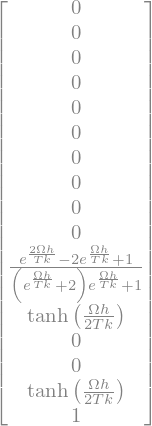

In [8]:
thermal_liou

Because the density operators in Liouville space formalism can be just added, we can integrate the superoperators over a range of orientations and then apply the result to a density matrix. This will yield a density matrix after the orientational average of the dipolar couplings takes effect. 

The dipolar interaction strength is given by $D(1-3\cos^2\theta)$, so the turning angle $\theta = D(1-3\cos^2\theta)t$ after time $t$.

In other words, any $\cos \theta $ terms in the ZZ rotation superoperator will be replaced by 

$$\frac{\int_{\theta_1}^{\theta_2} \cos \left[D(1-3\cos^2\theta)t\right] \sin \theta d\theta}{\int_{\theta_1}^{\theta_2}\sin \theta d\theta}$$

Where $D$ is the dipolar constant. Since only one angle matters, we need to add the Jacobian $\sin \theta$ there.
Accordingly, any $\sin \theta$ terms will be replaced by 

$$\frac{\int_{\theta_1}^{\theta_2} \sin \left[D(1-3\cos^2\theta)t\right] \sin \theta d\theta}{\int_{\theta_1}^{\theta_2}\sin \theta d\theta}$$

Let's evaluate that

$$\int_{\theta_1}^{\theta_2} \cos \left[D(1-3\cos^2\theta)t\right] \sin \theta d\theta = \cos (Dt) \int_{\theta_1}^{\theta_2}  \cos \left[3 D t\cos^2\theta \right] \sin \theta d\theta + \sin (Dt) \int_{\theta_1}^{\theta_2}  \sin \left[3 D t\cos^2\theta \right] \sin \theta d\theta$$

Similarly

$$\int_{\theta_1}^{\theta_2} \sin \left[D(1-3\cos^2\theta)t\right] \sin \theta d\theta = \sin (Dt) \int_{\theta_1}^{\theta_2}  \cos \left[3 D t\cos^2\theta \right] \sin \theta d\theta - \cos (Dt) \int_{\theta_1}^{\theta_2}  \sin \left[3 D t\cos^2\theta \right] \sin \theta d\theta$$

So it is enough to calculate

$$\int_{\theta_1}^{\theta_2}  \cos \left[3 D t\cos^2\theta \right] \sin \theta d\theta $$

and the other integral. 

Simple substitution $v = \sqrt{\frac{6Dt}{\pi}} \cos \theta, dv = -\sqrt{\frac{6Dt}{\pi}} sin \theta d \theta$ yields

$$\sqrt{\frac{\pi}{6Dt}} \int_{a}^{b}  \cos (\frac{\pi}2 v^2) dv $$

Where $a = \sqrt{\frac{6Dt}{\pi}} \cos \theta_2$ and $b = \sqrt{\frac{6Dt}{\pi}} \cos \theta_1$

And so the integral is equal to 

$$\sqrt{\frac{\pi}{6Dt}} \left( FrC \left(\sqrt{\frac{6Dt}{\pi}} \cos \theta_1 \right) - FrC\left(\sqrt{\frac{6Dt}{\pi}} \cos \theta_2 \right) \right)$$

Where $FrC(x)$ is Fresnel special cosine integral. 

The other integral just yields the same thing but with $FrS(x)$, Fresnel special sine integral, instead. 

It is also worth noting that 

$$\int_{\theta_1}^{\theta_2}\sin \theta d\theta = \cos \theta_1 - \cos \theta_2$$


In [9]:
def fr_repl(D,t,J=0,theta1=0,theta2=np.pi/2):
    arg = np.sqrt(6*D*t/np.pi)
    
    bound1 = arg*np.cos(theta1)
    bound2 = arg*np.cos(theta2)
    
    sc1, cc1 = fresnel(bound1)
    sc2, cc2 = fresnel(bound2)
    

    cos_repl = 1/arg*(np.cos((D+J)*t)*(cc1-cc2)+np.sin((D+J)*t)*(sc1-sc2))/(np.cos(theta1)-np.cos(theta2))
    sin_repl = 1/arg*(np.sin((D+J)*t)*(cc1-cc2)-np.cos((D+J)*t)*(sc1-sc2))/(np.cos(theta1)-np.cos(theta2))
    
    return cos_repl, sin_repl
    

In [10]:
LY1 = TensorProduct(LSY,eye(4))
RY1 = TensorProduct(RSY,eye(4))
LY2 = TensorProduct(eye(4),LSY)
RY2 = TensorProduct(eye(4),RSY)

RotY1 = simplify((cos(Rational(1,2)*theta)*eye(16)+2*I*sin(Rational(1,2)*theta)*RY1)*(cos(Rational(1,2)*theta)*eye(16)-2*I*sin(Rational(1,2)*theta)*LY1))
RotY2 = simplify((cos(Rational(1,2)*theta)*eye(16)+2*I*sin(Rational(1,2)*theta)*RY2)*(cos(Rational(1,2)*theta)*eye(16)-2*I*sin(Rational(1,2)*theta)*LY2))

RotY12 = RotY2*RotY1

LSZ1Z2 = TensorProduct(LSZ,LSZ)
RSZ1Z2 = TensorProduct(RSZ,RSZ)

RotZZ = simplify((cos(Rational(1,2)*phi)*eye(16)+4*I*sin(Rational(1,2)*phi)*RSZ1Z2)*(cos(Rational(1,2)*phi)*eye(16)-4*I*sin(Rational(1,2)*phi)*LSZ1Z2))

In [13]:
cos_pairs = []
sin_pairs = []
msin_pairs = []

genrot = np.zeros([16,16])


for i in range(16):
    for j in range(16):
        a = simplify(RotZZ[i,j]-cos(phi))
        b = simplify(RotZZ[i,j]-sin(phi))
        c = simplify(RotZZ[i,j]+sin(phi))
        d = simplify(RotZZ[i,j]-1)
        
        if a==0:
        
            cos_pairs.append((i,j))
        
        elif b==0:
            
            sin_pairs.append((i,j))
        elif c==0:
            
            msin_pairs.append((i,j))
        
        elif d==0:
            genrot[i,j] = 1

In [14]:
def Entanglement_angles_temperature(n,D,J,time,th1,th2,temp,freq):
    
    print("Full angular average between colatitudes {0} and {1} degrees.".format(int(180/np.pi*th1),int(180/np.pi*th2)))
    print("Thermal state in temperature {0} K".format(temp))
    print("Resonant frequency {0} GHz".format(int(freq*10**-9)))
    print("Ratio between J and D: {0}".format(J/D))
    
    t = np.linspace(time,0,n,endpoint=False)
    ent = np.zeros(n)

    # thermal state
    if temp:
        rho0 = thermal_liou.subs(kB,cnst.k).subs(h,cnst.Planck).subs(T,temp).subs(Omega,freq)
    else: 
        A = Matrix([0,0,1,1])
        rho0 = TensorProduct(A,A)

    cos_repl, sin_repl = fr_repl(D,t,J=J,theta1=th1,theta2=th2)

    for i in range(n):
    
        rot = genrot
    
        for pair in cos_pairs:
            rot[pair[0],pair[1]] = cos_repl[i]
        for pair in sin_pairs:
            rot[pair[0],pair[1]] = sin_repl[i]
        for pair in msin_pairs:
            rot[pair[0],pair[1]] = -sin_repl[i]
    
        Rot = Matrix(rot)
        
        #initial state hard pulsed in Y
        rho = RotY12.subs(theta,pi/2)*rho0
        rho = Rot*rho
        rho = prod_op_to_hilbert(rho)
        rho = matrix2numpy(rho,dtype=complex)
        ent[i] = logneg(rho)

    plt.figure()
    plt.plot(t,ent, label='log-negativity')
    plt.plot(t,cos_repl, label='in phase DEER')
    plt.plot(t,sin_repl, label='out of phase DEER')
    plt.legend()
    plt.xlabel('interaction time [a.u]')
    #plt.title('Log-negativity and DEER, colatitudes: {0} to {1}, temp: {2}  K, frq {3} GHz'.format(int(180/np.pi*th1),int(180/np.pi*th2),temp,int(freq*10**-9)))
    
    return ent

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 100000.0


<IPython.core.display.Javascript object>


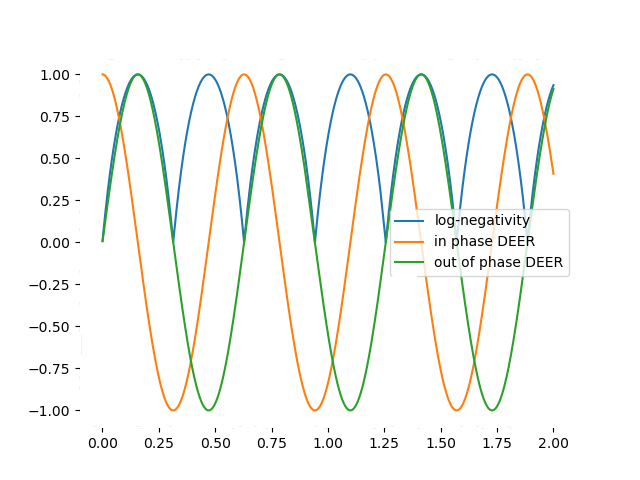

Text(0.5, 1.0, 'Log-negativity and DEER signal, J-dominated system, full angular average')

In [16]:
n = 3000
D = 0.0001
J = 10
final_time = 2
angle_1 = 0*np.pi/180
angle_2 = 90*np.pi/180
temperature = .001 # K
frequency = 33*10**9 #Hz

entee = Entanglement_angles_temperature(n,D,J,final_time,angle_1,angle_2,temperature,frequency)
plt.title('Log-negativity and DEER signal, J-dominated system, full angular average')
#plt.savefig('Logneg_J.png',format='png')

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.0


<IPython.core.display.Javascript object>


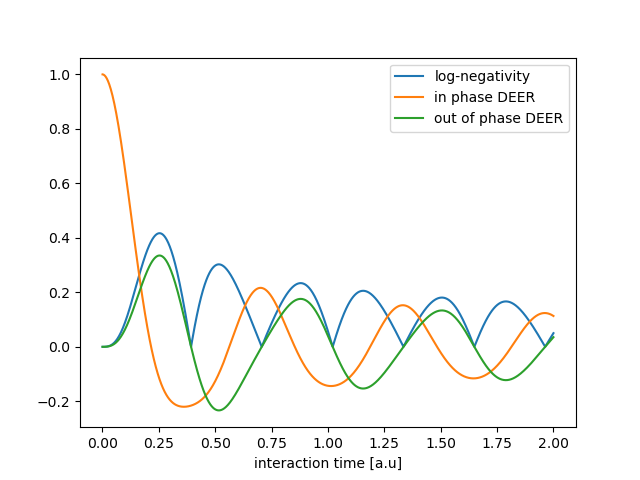

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 100000.0


<IPython.core.display.Javascript object>


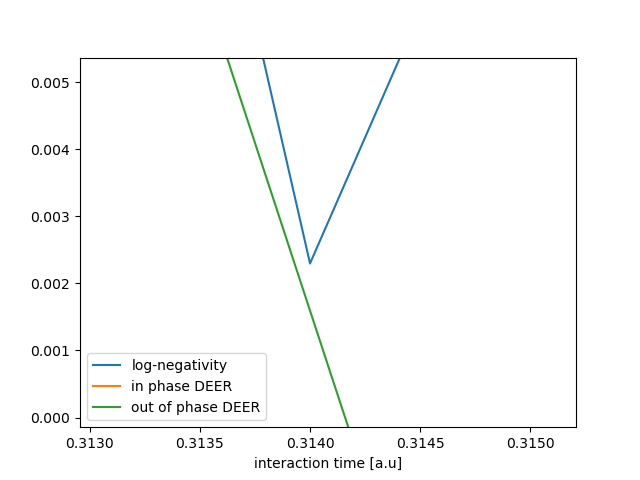

In [17]:
Ddom0K = Entanglement_angles_temperature(n,10,0,final_time,angle_1,angle_2,0.001,frequency)
Jdom0K = Entanglement_angles_temperature(n,0.0001,10,final_time,angle_1,angle_2,0.001,frequency)
#Ddom0p5K = Entanglement_angles_temperature(n,10,0,final_time,angle_1,angle_2,0.5,frequency)
#Jdom0p5K = Entanglement_angles_temperature(n,0.0001,10,final_time,angle_1,angle_2,0.5,frequency)

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.8 K
Resonant frequency 33 GHz
Ratio between J and D: 0.0


<IPython.core.display.Javascript object>


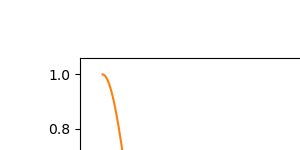

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.8 K
Resonant frequency 33 GHz
Ratio between J and D: 100000.0


<IPython.core.display.Javascript object>


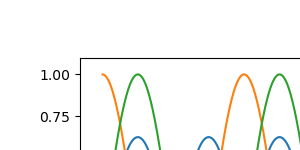

In [18]:
Ddom0p8K = Entanglement_angles_temperature(n,10,0,final_time,angle_1,angle_2,0.8,frequency)
Jdom0p8K = Entanglement_angles_temperature(n,0.0001,10,final_time,angle_1,angle_2,0.8,frequency)

<IPython.core.display.Javascript object>


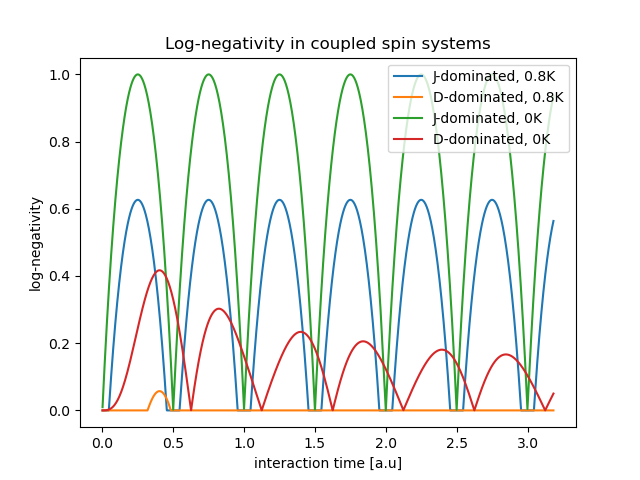

Text(0.5, 1.0, 'Log-negativity in coupled spin systems')

In [23]:
plt.figure()
t_axis = np.linspace(final_time,0,n,endpoint=False)/np.pi*5
plt.plot(t_axis,Jdom0p8K,label='J-dominated, 0.8K')
plt.plot(t_axis,Ddom0p8K,label='D-dominated, 0.8K')
plt.plot(t_axis,Jdom0K,label='J-dominated, 0K')
plt.plot(t_axis,Ddom0K,label='D-dominated, 0K')


plt.legend(loc='upper right')
plt.xlabel('interaction time [a.u]')
plt.ylabel('log-negativity')
plt.title('Log-negativity in coupled spin systems')
#plt.savefig('logneg-comparisonDJ.png',format='png')

In [25]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))

<IPython.core.display.Javascript object>


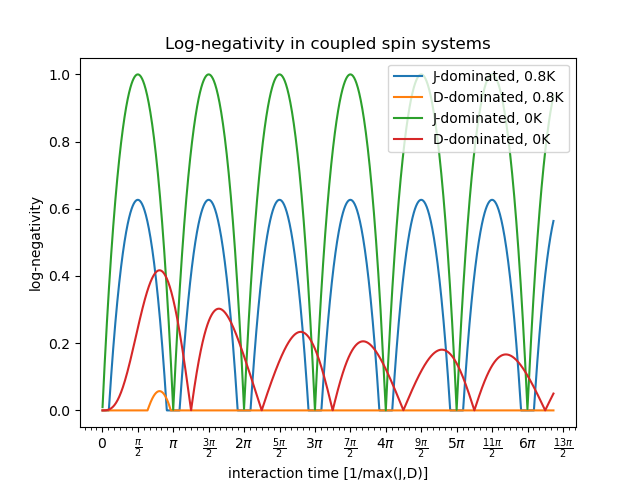

In [32]:
plt.figure()
t_axis = np.linspace(final_time,0,n,endpoint=False)*10
plt.plot(t_axis,Jdom0p8K,label='J-dominated, 0.8K')
plt.plot(t_axis,Ddom0p8K,label='D-dominated, 0.8K')
plt.plot(t_axis,Jdom0K,label='J-dominated, 0K')
plt.plot(t_axis,Ddom0K,label='D-dominated, 0K')

plt.legend(loc='upper right')
plt.xlabel('interaction time [1/max(J,D)]')
plt.ylabel('log-negativity')
plt.title('Log-negativity in coupled spin systems')

ax = plt.gca()
#ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 12))
ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))

plt.savefig('logneg-comparisonDJ.png',format='png')

In [17]:
from operator import itemgetter
max(zip(np.linspace(final_time,0,n,endpoint=False),entee),key=itemgetter(1))[0]

(array([ 1.93953545e-01,  1.92073265e-01,  1.90162730e-01, ...,
        -3.20342650e-16,  0.00000000e+00, -1.60171325e-16]),
 array([2.00000000e+00, 1.99933333e+00, 1.99866667e+00, ...,
        2.00000000e-03, 1.33333333e-03, 6.66666667e-04]))

In [71]:
int(3000-3000*0.235/2)

In [58]:
np.linspace(2,0,n,endpoint=False)[2625]

In [74]:
N = 3000
D = 10
J = 0
angle_1 = 0*np.pi/180
angle_2 = 90*np.pi/180
frequency = 33*10**9 #Hz

probing_temps = np.linspace(0.001,3,N)
max_ent = np.zeros(N)
t = 0.25 #max for D=10,J=0

cos_repl, sin_repl = fr_repl(D,t,J=J,theta1=angle_1,theta2=angle_2)
    
rot = genrot
    
for pair in cos_pairs:
    rot[pair[0],pair[1]] = cos_repl
for pair in sin_pairs:
    rot[pair[0],pair[1]] = sin_repl
for pair in msin_pairs:
    rot[pair[0],pair[1]] = -sin_repl
    
Rot = Matrix(rot)

for i in range(N):

    rho0 = thermal_liou.subs(kB,cnst.k).subs(h,cnst.Planck).subs(T,probing_temps[i]).subs(Omega,frequency)
    
    rho = RotY12.subs(theta,pi/2)*rho0
    rho = Rot*rho
    rho = prod_op_to_hilbert(rho)
    rho = matrix2numpy(rho,dtype=complex)
    max_ent[i] = logneg(rho)

<IPython.core.display.Javascript object>


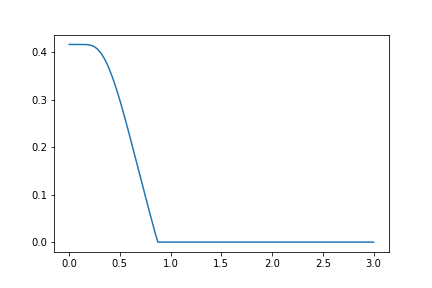

In [75]:
plt.figure()
plt.plot(probing_temps,max_ent)

In [76]:
N = 3000
D = 10
J = 0
angle_1 = 0*np.pi/180
angle_2 = 0.1*np.pi/180
frequency = 33*10**9 #Hz

probing_temps = np.linspace(0.001,3,N)
max_ent_1 = np.zeros(N)
t = 0.235 #max for D=10,J=0

cos_repl, sin_repl = fr_repl(D,t,J=J,theta1=angle_1,theta2=angle_2)
    
rot = genrot
    
for pair in cos_pairs:
    rot[pair[0],pair[1]] = cos_repl
for pair in sin_pairs:
    rot[pair[0],pair[1]] = sin_repl
for pair in msin_pairs:
    rot[pair[0],pair[1]] = -sin_repl
    
Rot = Matrix(rot)

for i in range(N):

    rho0 = thermal_liou.subs(kB,cnst.k).subs(h,cnst.Planck).subs(T,probing_temps[i]).subs(Omega,frequency)
    
    rho = RotY12.subs(theta,pi/2)*rho0
    rho = Rot*rho
    rho = prod_op_to_hilbert(rho)
    rho = matrix2numpy(rho,dtype=complex)
    max_ent_1[i] = logneg(rho)

<IPython.core.display.Javascript object>


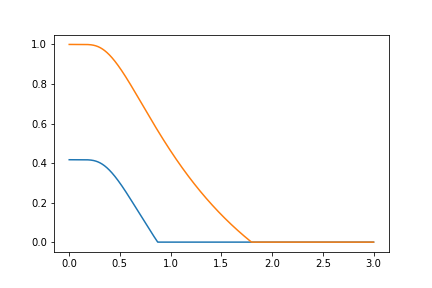

In [78]:
plt.figure()
plt.plot(probing_temps,max_ent)
plt.plot(probing_temps,max_ent_1)

In [85]:
N = 3000
D = 10
J = 0
angle_1 = 89.9*np.pi/180
angle_2 = 90*np.pi/180
frequency = 33*10**9 #Hz

probing_temps = np.linspace(0.001,3,N)
max_ent_2 = np.zeros(N)
t = 0.78533 #max for D=10,J=0

cos_repl, sin_repl = fr_repl(D,t,J=J,theta1=angle_1,theta2=angle_2)
    
rot = genrot
    
for pair in cos_pairs:
    rot[pair[0],pair[1]] = cos_repl
for pair in sin_pairs:
    rot[pair[0],pair[1]] = sin_repl
for pair in msin_pairs:
    rot[pair[0],pair[1]] = -sin_repl
    
Rot = Matrix(rot)

for i in range(N):

    rho0 = thermal_liou.subs(kB,cnst.k).subs(h,cnst.Planck).subs(T,probing_temps[i]).subs(Omega,frequency)
    
    rho = RotY12.subs(theta,pi/2)*rho0
    rho = Rot*rho
    rho = prod_op_to_hilbert(rho)
    rho = matrix2numpy(rho,dtype=complex)
    max_ent_2[i] = logneg(rho)

<IPython.core.display.Javascript object>


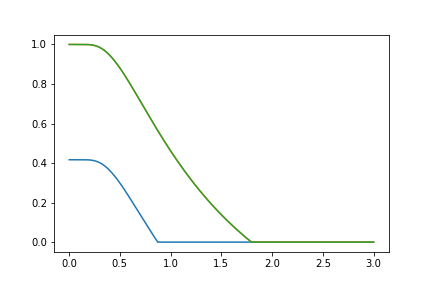

In [86]:
plt.figure()
plt.plot(probing_temps,max_ent)
plt.plot(probing_temps,max_ent_1)
plt.plot(probing_temps,max_ent_2)

In [91]:
N = 3000
D = 10
J = 5
angle_1 = 0*np.pi/180
angle_2 = 90*np.pi/180
frequency = 33*10**9 #Hz

probing_temps = np.linspace(0.001,3,N)
max_ent_3 = np.zeros(N)
t = 0.120667 #max for D=10,J=5

cos_repl, sin_repl = fr_repl(D,t,J=J,theta1=angle_1,theta2=angle_2)
    
rot = genrot
    
for pair in cos_pairs:
    rot[pair[0],pair[1]] = cos_repl
for pair in sin_pairs:
    rot[pair[0],pair[1]] = sin_repl
for pair in msin_pairs:
    rot[pair[0],pair[1]] = -sin_repl
    
Rot = Matrix(rot)

for i in range(N):

    rho0 = thermal_liou.subs(kB,cnst.k).subs(h,cnst.Planck).subs(T,probing_temps[i]).subs(Omega,frequency)
    
    rho = RotY12.subs(theta,pi/2)*rho0
    rho = Rot*rho
    rho = prod_op_to_hilbert(rho)
    rho = matrix2numpy(rho,dtype=complex)
    max_ent_3[i] = logneg(rho)

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.0


<IPython.core.display.Javascript object>


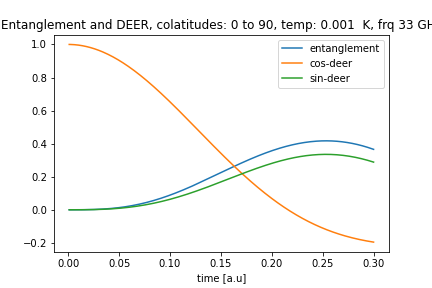

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.002 K
Resonant frequency 33 GHz
Ratio between J and D: 0.0


<IPython.core.display.Javascript object>


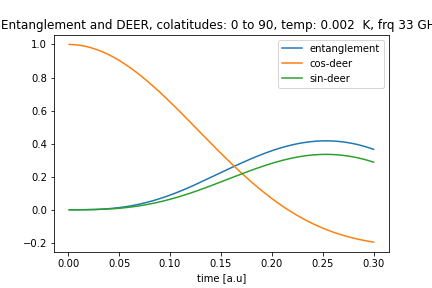

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.003 K
Resonant frequency 33 GHz
Ratio between J and D: 0.0


<IPython.core.display.Javascript object>


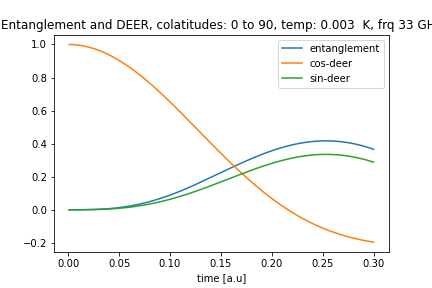

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.004 K
Resonant frequency 33 GHz
Ratio between J and D: 0.0


<IPython.core.display.Javascript object>


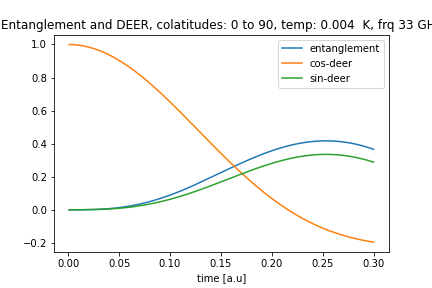

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.005 K
Resonant frequency 33 GHz
Ratio between J and D: 0.0


KeyboardInterrupt: 

In [52]:
probing_temps = np.linspace(0.001,1,1000)
max_ent = np.zeros(1000)
threshold = 1e-15
for i in range(1000):
    ent = Entanglement_angles_temperature(n,D,J,0.3,angle_1,angle_2,probing_temps[i],frequency)
    max_ent[i] = max(ent)

<IPython.core.display.Javascript object>


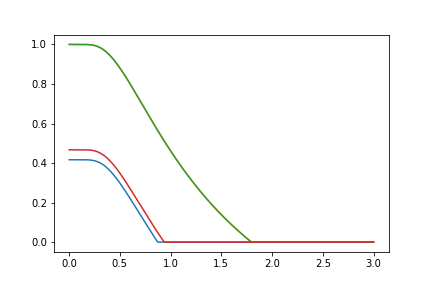

In [92]:
plt.figure()
plt.plot(probing_temps,max_ent)
plt.plot(probing_temps,max_ent_1)
plt.plot(probing_temps,max_ent_2)
plt.plot(probing_temps,max_ent_3)

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.0005


<IPython.core.display.Javascript object>


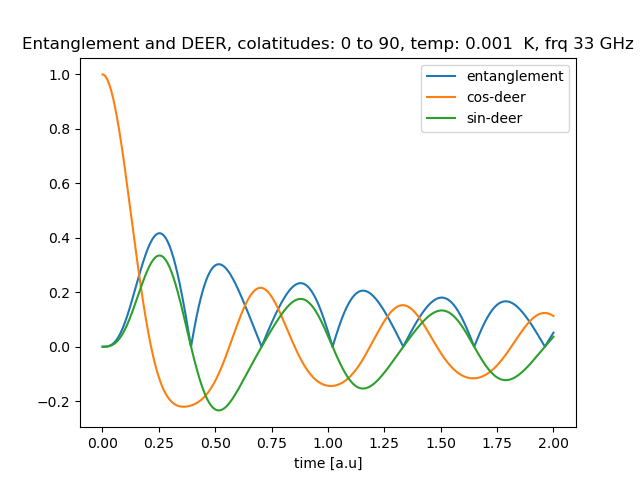

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.001


<IPython.core.display.Javascript object>


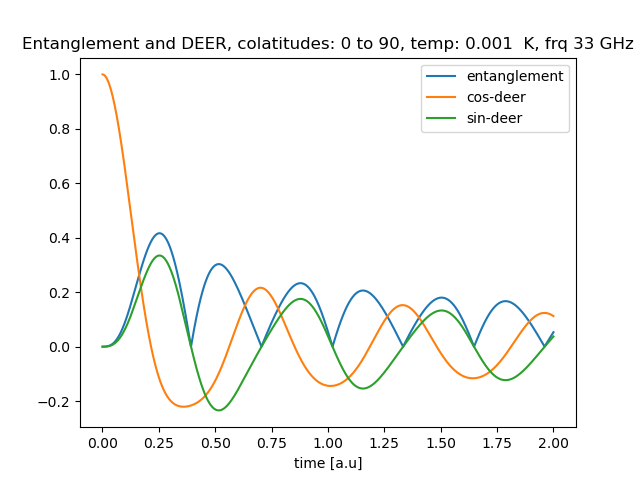

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.005


<IPython.core.display.Javascript object>


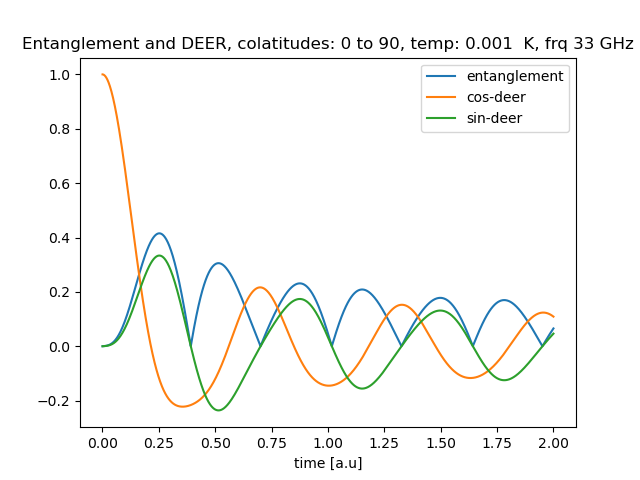

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.01


<IPython.core.display.Javascript object>


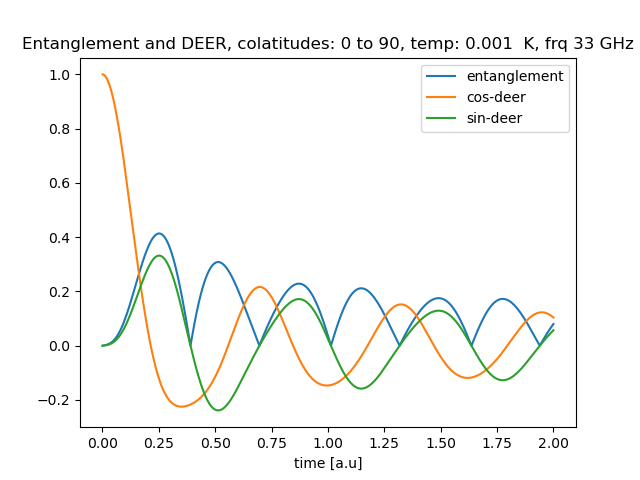

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.003


<IPython.core.display.Javascript object>


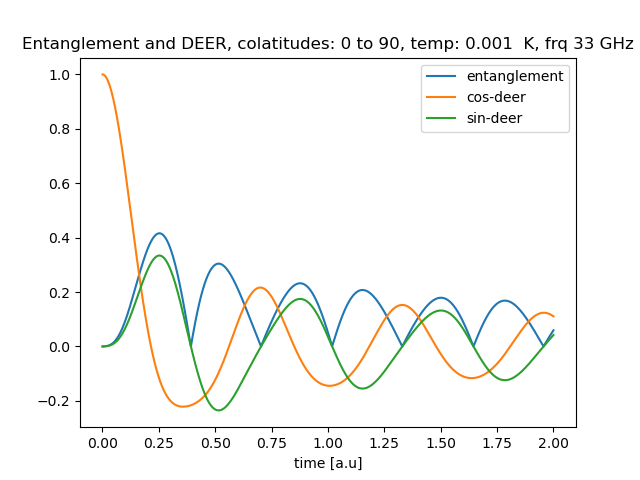

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.05


<IPython.core.display.Javascript object>


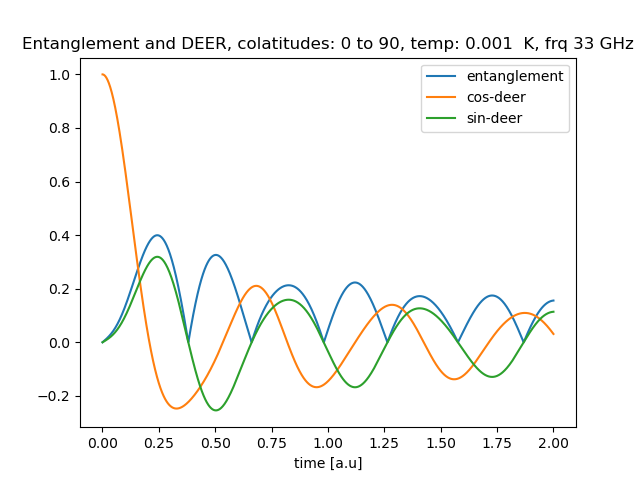

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.08


<IPython.core.display.Javascript object>


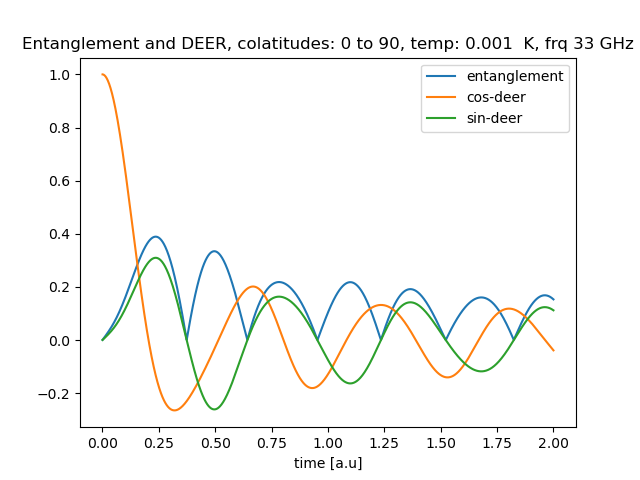

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.1


<IPython.core.display.Javascript object>


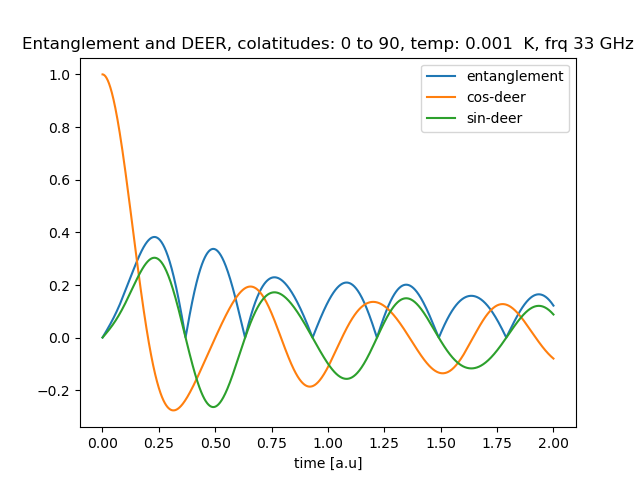

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.15


<IPython.core.display.Javascript object>


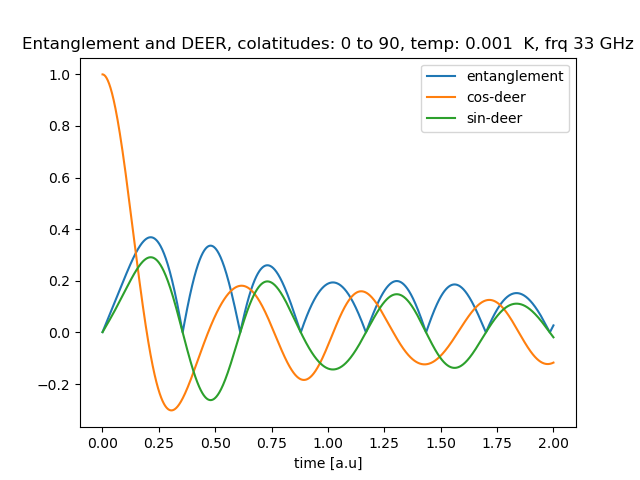

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.2


<IPython.core.display.Javascript object>


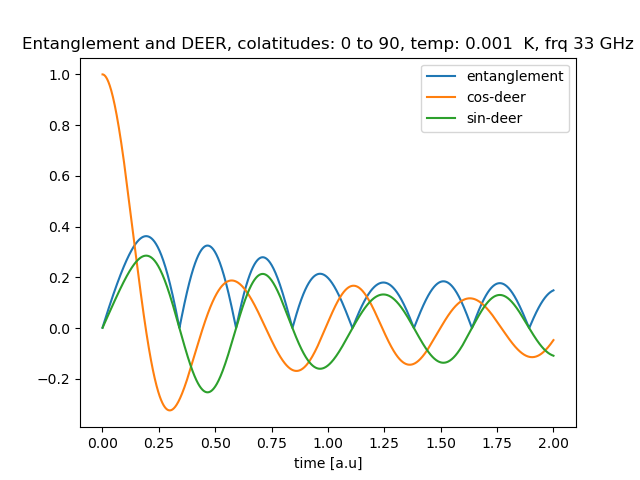

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.3


<IPython.core.display.Javascript object>


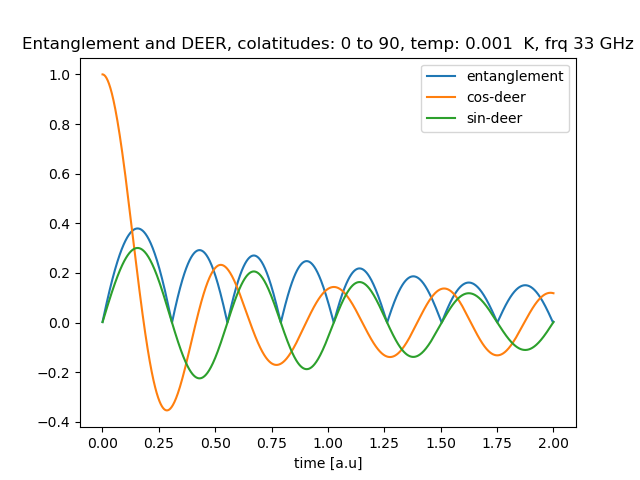

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.4


<IPython.core.display.Javascript object>


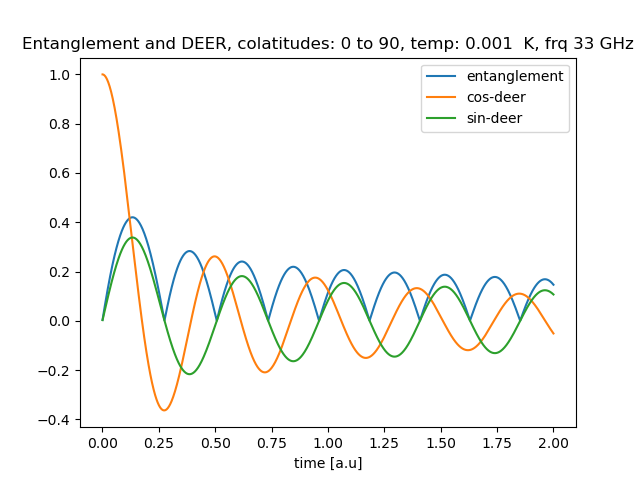

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.5


<IPython.core.display.Javascript object>


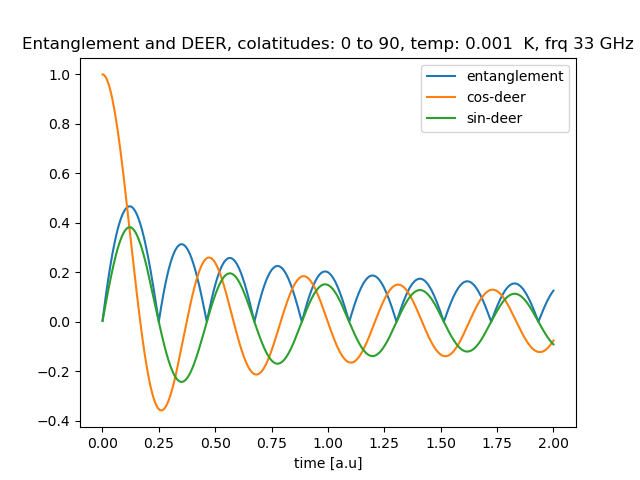

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.6


<IPython.core.display.Javascript object>


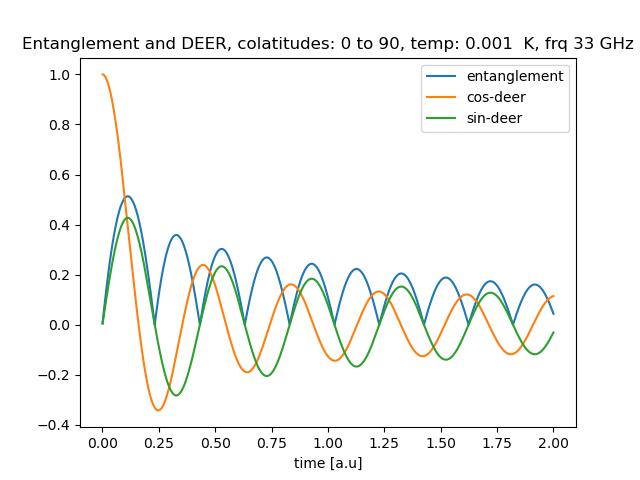

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.7


<IPython.core.display.Javascript object>


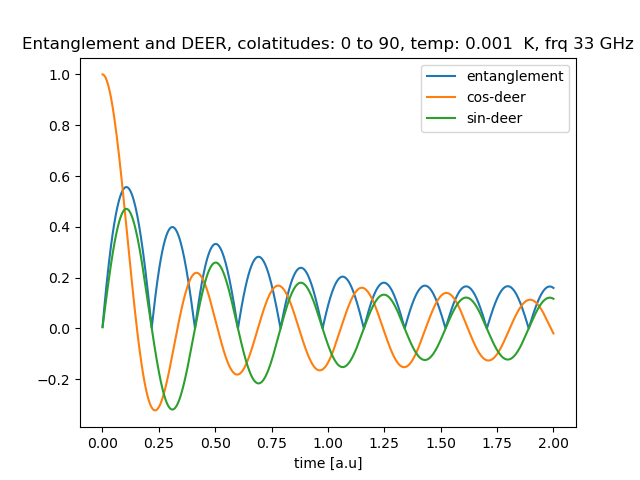

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.8


<IPython.core.display.Javascript object>


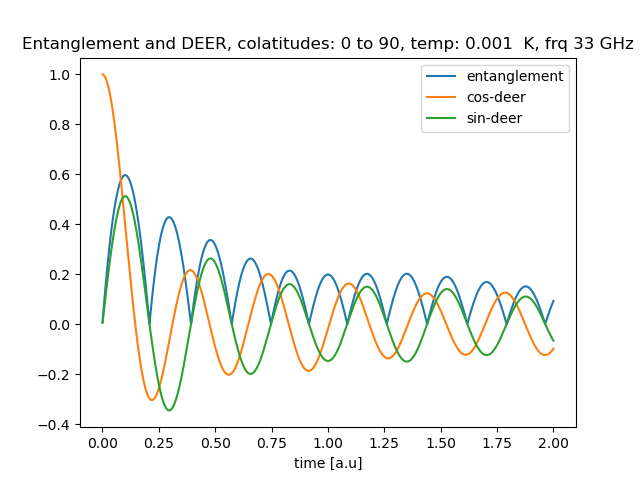

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 0.9


<IPython.core.display.Javascript object>


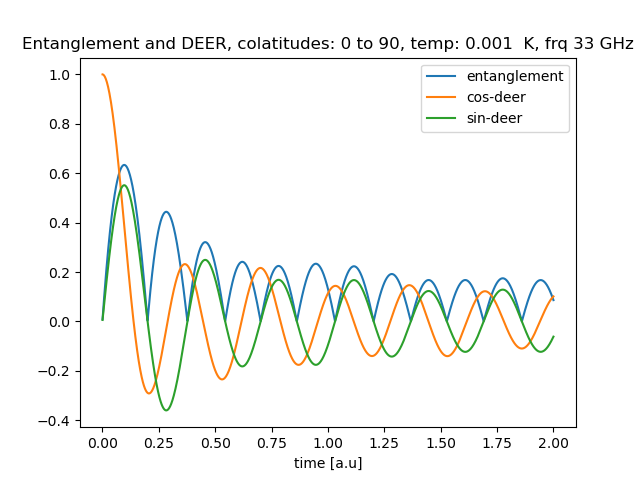

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 1.0


<IPython.core.display.Javascript object>


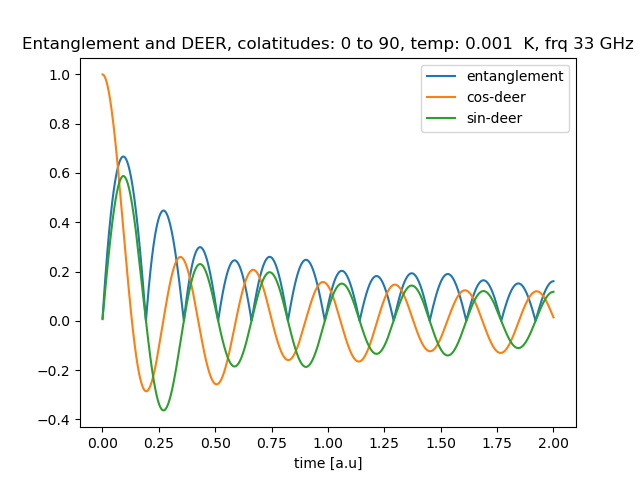

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 1.1111111111111112


<IPython.core.display.Javascript object>


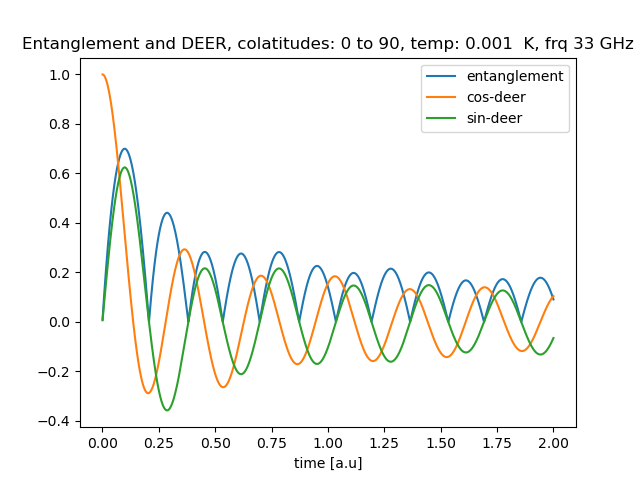

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 1.25


<IPython.core.display.Javascript object>


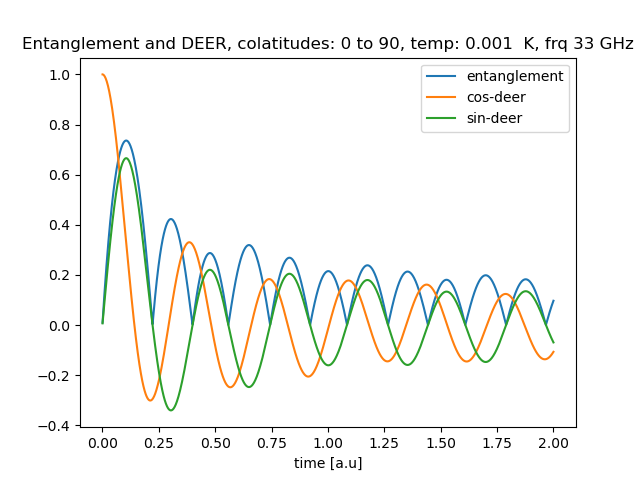

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 1.4285714285714286


<ipython-input-15-3eb28f2e4b71>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<IPython.core.display.Javascript object>


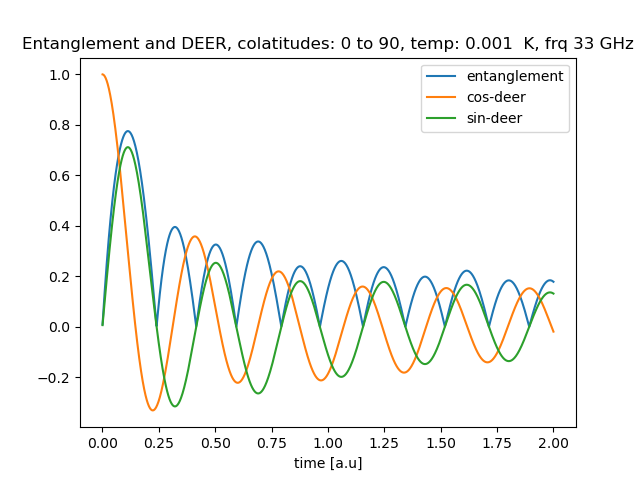

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 1.6666666666666667


<IPython.core.display.Javascript object>


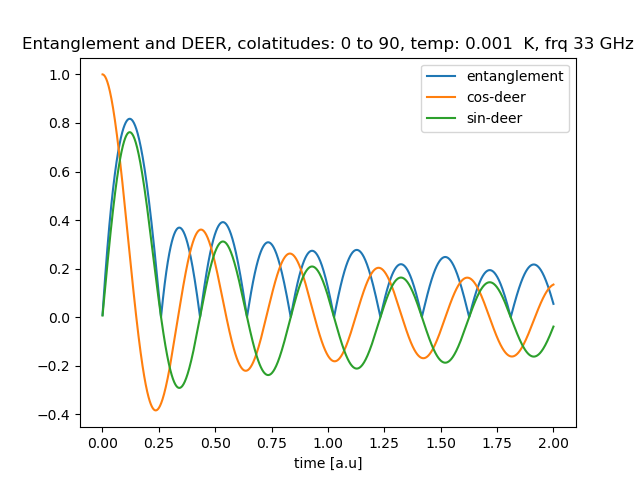

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 2.0


<IPython.core.display.Javascript object>


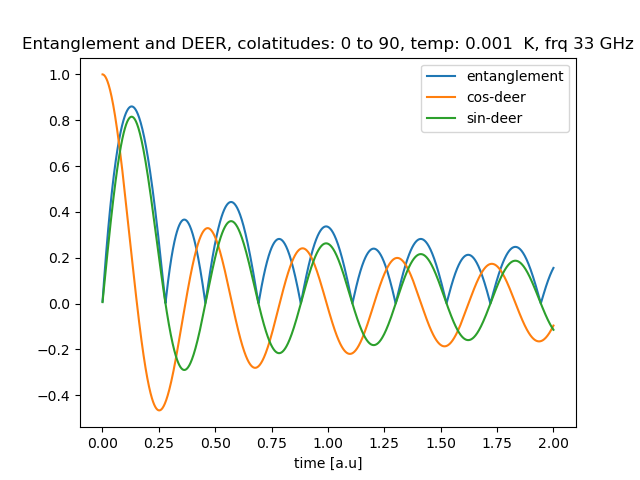

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 2.5


<IPython.core.display.Javascript object>


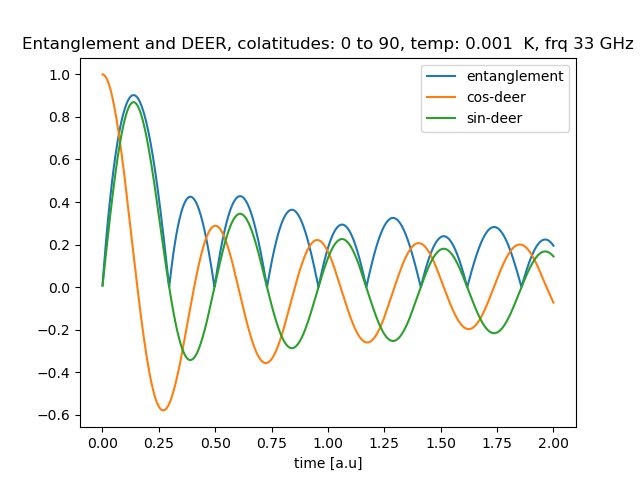

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 3.3333333333333335


<IPython.core.display.Javascript object>


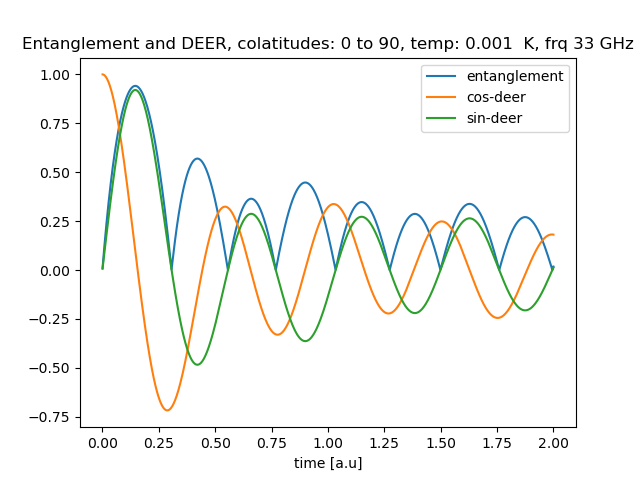

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 5.0


<IPython.core.display.Javascript object>


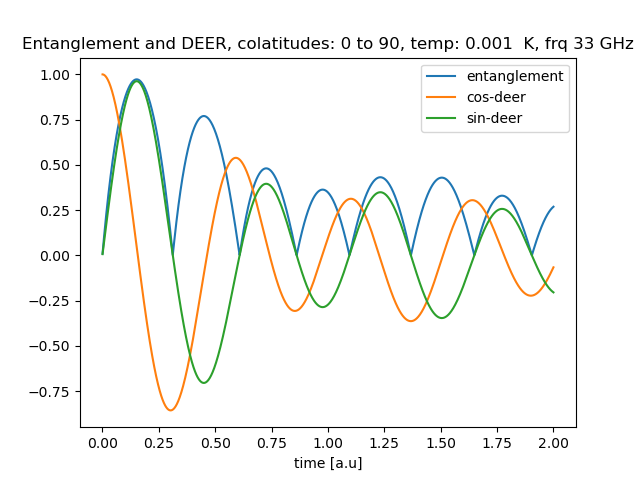

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 10.0


<IPython.core.display.Javascript object>


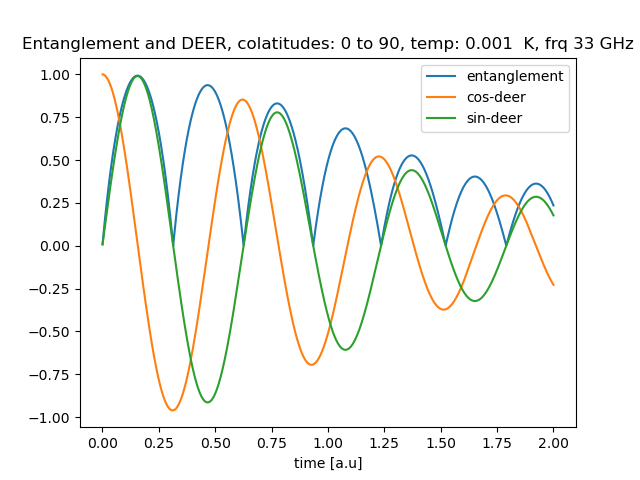

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 20.0


<IPython.core.display.Javascript object>


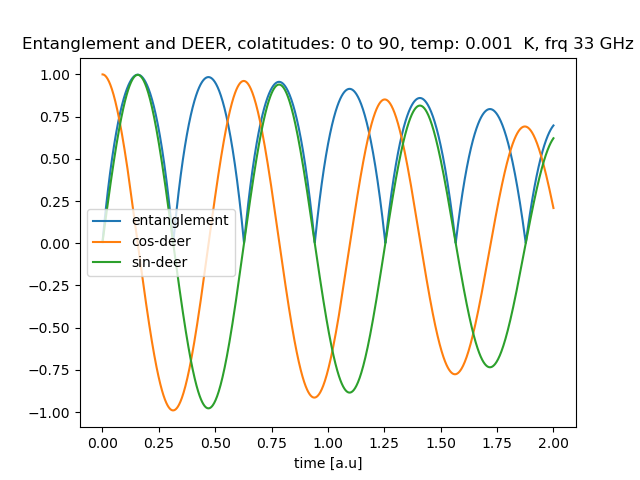

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 100.0


<IPython.core.display.Javascript object>


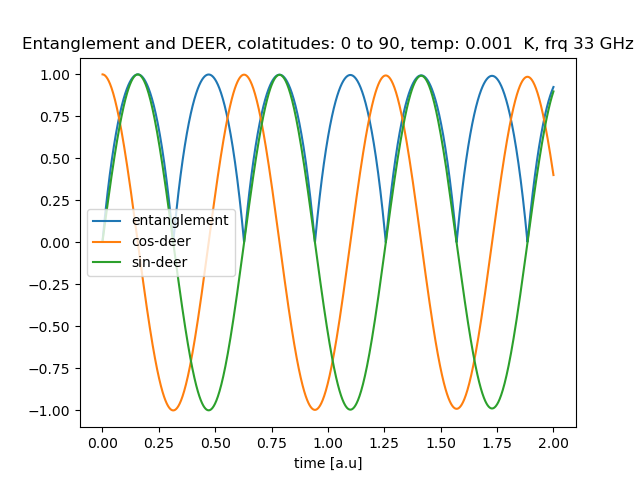

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 200.0


<IPython.core.display.Javascript object>


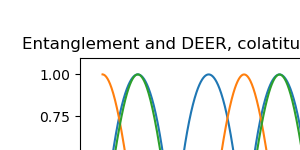

Full angular average between colatitudes 0 and 90 degrees.
Thermal state in temperature 0.001 K
Resonant frequency 33 GHz
Ratio between J and D: 1000.0


<IPython.core.display.Javascript object>


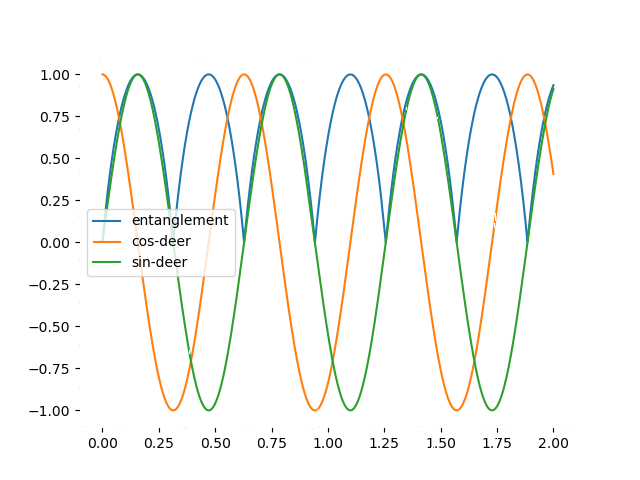

In [18]:
DJpairs = [(10,0.005),(10,0.01),(10,0.05),(10,0.1),(10,0.03),(10,0.5),(10,0.8),(10,1),(10,1.5),(10,2),(10,3),(10,4),(10,5),(10,6),(10,7),(10,8),(10,9),(10,10),(9,10),(8,10),(7,10),(6,10),(5,10),(4,10),(3,10),(2,10),(1,10),(0.5,10),(0.1,10),(0.05,10),(0.01,10)]

N = 3000 #temp stepps
n = 3000 #time steps
probing_temps = np.linspace(0.001,3,N)

max_ent_DJ = {}

for DJpair in DJpairs:
    
    D = DJpair[0]
    J = DJpair[1]
    angle_1 = 0*np.pi/180
    angle_2 = 90*np.pi/180
    frequency = 33*10**9 #Hz
    
    final_time = 2
    temperature = .001 # K
    
    entee = Entanglement_angles_temperature(n,D,J,final_time,angle_1,angle_2,temperature,frequency)
    plt.savefig('entaverage_D='+str(D)+', J='+str(J)+'.png',format='png')
    
    max_time = max(zip(np.linspace(final_time,0,n,endpoint=False),entee),key=itemgetter(1))[0]
    

    max_ent = np.zeros(N)

    cos_repl, sin_repl = fr_repl(D,max_time,J=J,theta1=angle_1,theta2=angle_2)
    
    rot = genrot
    
    for pair in cos_pairs:
        rot[pair[0],pair[1]] = cos_repl
    for pair in sin_pairs:
        rot[pair[0],pair[1]] = sin_repl
    for pair in msin_pairs:
        rot[pair[0],pair[1]] = -sin_repl
    
    Rot = Matrix(rot)

    for i in range(N):

        rho0 = thermal_liou.subs(kB,cnst.k).subs(h,cnst.Planck).subs(T,probing_temps[i]).subs(Omega,frequency)
    
        rho = RotY12.subs(theta,pi/2)*rho0
        rho = Rot*rho
        rho = prod_op_to_hilbert(rho)
        rho = matrix2numpy(rho,dtype=complex)
        max_ent[i] = logneg(rho)
    
    max_ent_DJ[DJpair] = max_ent

<IPython.core.display.Javascript object>


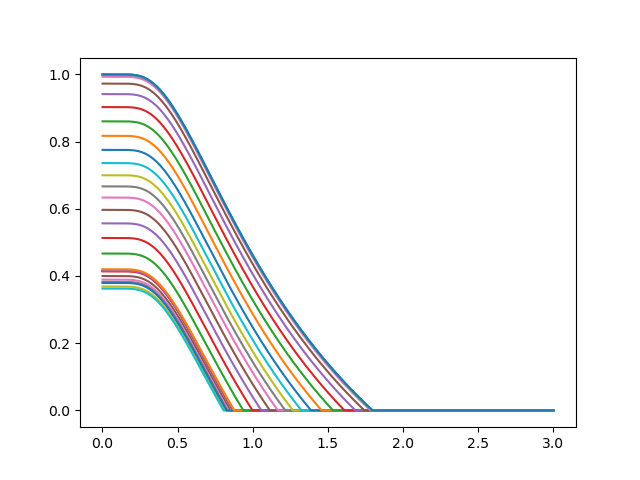

In [19]:
plt.figure()
total_max_ent = {}
ent_cutoff = {}
threshold = 1e-16

x_axis = probing_temps*cnst.k/(frequency*cnst.Planck)
for DJpair in DJpairs:
    plt.plot(probing_temps,max_ent_DJ[DJpair],label=str(DJpair))
    total_max_ent[DJpair] = max_ent_DJ[DJpair][0]
    ent_cutoff[DJpair] = next(x[0] for x in zip(x_axis,max_ent_DJ[DJpair]) if x[1]<threshold)
    #plt.legend()

<IPython.core.display.Javascript object>


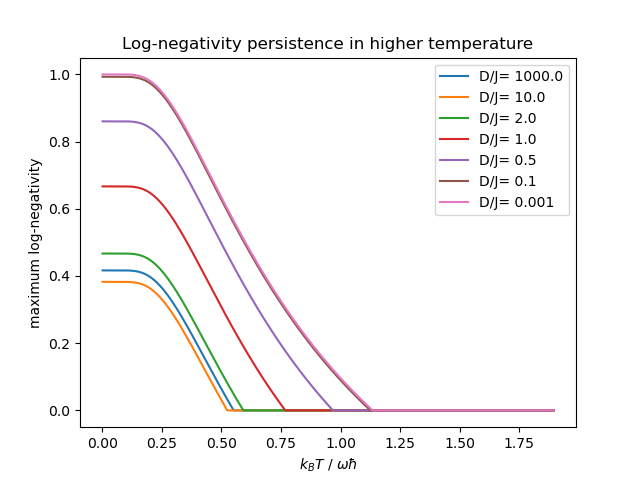

In [22]:
plt.figure()


x_axis = probing_temps*cnst.k/(frequency*cnst.Planck)
for DJpair in [(10,0.01), (10,1), (10,5),(10,10),(5,10),(1,10),(0.01,10)]:
    plt.plot(x_axis,max_ent_DJ[DJpair],label='D/J= '+str(DJpair[0]/DJpair[1]))
plt.legend()
plt.title('Log-negativity persistence in higher temperature')
plt.xlabel(r'$k_B T$ / $\omega \hbar$')
plt.ylabel('maximum log-negativity')
plt.savefig('log-neg_persistence.png',format='png')

In [28]:
np.save('max_end_DJ.npy',max_ent_DJ)

In [14]:
max_ent_DJ_copy = np.load('max_end_DJ.npy',allow_pickle='TRUE').item()

In [19]:
N = 3000 #temp stepps
n = 3000 #time steps
probing_temps = np.linspace(0.001,3,N)

angle_1 = 0*np.pi/180
angle_2 = 90*np.pi/180
frequency = 33*10**9 #Hz

max_ent_DJ = max_ent_DJ_copy

In [33]:
max_ent_DJ_copy[(,10)]

array([0.99999696, 0.99999696, 0.99999696, ..., 0.        , 0.        ,
       0.        ])

<IPython.core.display.Javascript object>


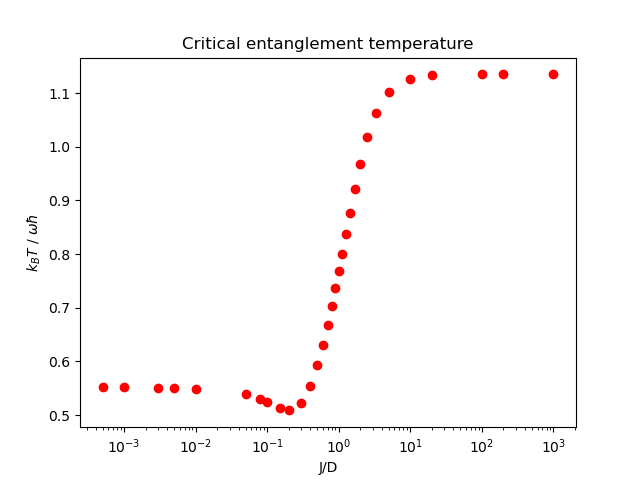

In [64]:
plt.figure()
plt.title('Critical entanglement temperature')
plt.xscale('log')
plt.ylabel(r'$k_B T$ / $\omega \hbar$')
plt.xlabel('J/D')
for DJpair in DJpairs:
    plt.scatter(DJpair[1]/DJpair[0],ent_cutoff[DJpair],color='red')
plt.savefig('log-neg_critT.png',format='png')

<IPython.core.display.Javascript object>


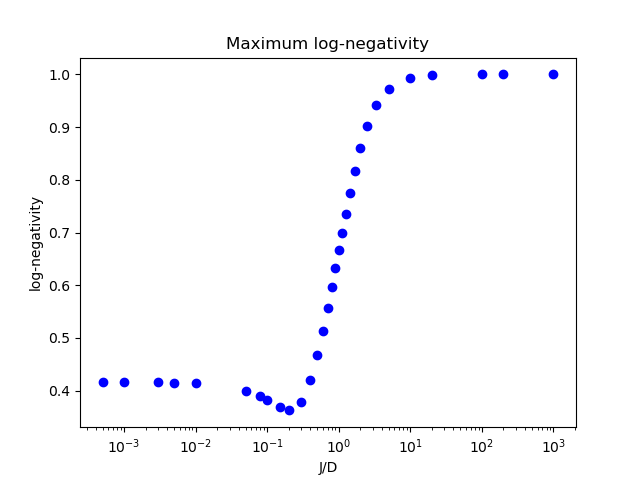

In [65]:
plt.figure()
plt.xscale('log')
plt.title('Maximum log-negativity')
plt.ylabel('log-negativity')
plt.xlabel('J/D')
for DJpair in DJpairs:
    plt.scatter(DJpair[1]/DJpair[0],total_max_ent[DJpair],color='blue')
plt.savefig('log-neg_max.png',format='png')

In [115]:
ent_cutoff

In [111]:
import bisect
bisect.bisect_left(max_ent_DJ[DJpair], 1e-16)

In [113]:
next(x[0] for x in zip(x_axis,max_ent_DJ[DJpair]) if x[1]<1e-16)

Text(0.5,1,'Entanglement and DEER, angles: 0 to 5, temp: 5  K, frq 133 GHz')

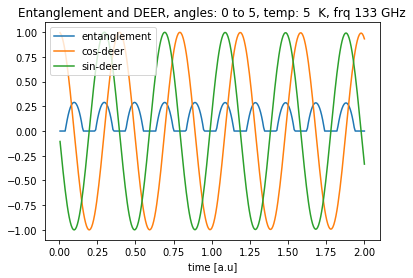

In [434]:
#def Entanglement_angles_temperature(n,D,time,th1,th2,temp,freq):
n = 300
D = 8
time = 2
th1 = 0
th2 = 0.1
temp = 5
freq = 133*10**9

t = np.linspace(time,0,n,endpoint=False)
ent = np.zeros(n)

# thermal state
if temp:
    rho0 = thermal_liou.subs(kB,cnst.k).subs(h,cnst.Planck).subs(T,temp).subs(Omega,freq)
else: 
    A = Matrix([0,0,1,1])
    rho0 = TensorProduct(A,A)
    
#initial state hard pulsed in X
rho = rho0
rho = RotY12*rho

cos_repl, sin_repl = fr_repl(D,t,theta1=th1,theta2=th2)

for i in range(n):
    
    rot = genrot
    
    for pair in cos_pairs:
        rot[pair[0],pair[1]] = cos_repl[i]
    for pair in sin_pairs:
        rot[pair[0],pair[1]] = sin_repl[i]
    for pair in msin_pairs:
        rot[pair[0],pair[1]] = -sin_repl[i]
    
    Rot = Matrix(rot)
        
    rho = RotY12.subs(theta,pi/2)*rho0
    rho = Rot*rho
    rho = prod_op_to_hilbert(rho)
    rho = matrix2numpy(rho,dtype=complex)
    ent[i] = logneg(rho)

plt.figure()
plt.plot(t,ent, label='entanglement')
plt.plot(t,cos_repl, label='cos-deer')
plt.plot(t,sin_repl, label='sin-deer')
plt.legend()
plt.xlabel('time [a.u]')
plt.title('Entanglement and DEER, angles: {0} to {1}, temp: {2}  K, frq {3} GHz'.format(int(180/np.pi*th1),int(180/np.pi*th2),temp,int(freq*10**-9)))

In [408]:
k

Text(0.5,1,'Entanglement and DEER, angles: 0 and 5, temp:  K')

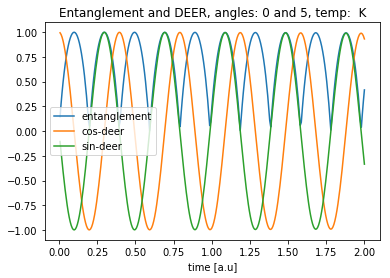

In [418]:
n = 300
D = 8
t = np.linspace(2,0,n,endpoint=False)
th1 = 0
th2 = 0.1
ent = np.zeros(n)

#Starting in an X state for simplicity
A = Matrix([1,0,0,1])
rho = TensorProduct(A,A)

cos_repl, sin_repl = fr_repl(D,t,theta1=th1,theta2=th2)

for i in range(n):
    
    rot = genrot
    
    for pair in cos_pairs:
        rot[pair[0],pair[1]] = cos_repl[i]
    for pair in sin_pairs:
        rot[pair[0],pair[1]] = sin_repl[i]
    for pair in msin_pairs:
        rot[pair[0],pair[1]] = -sin_repl[i]
    
    Rot = Matrix(rot)
        
    rho = TensorProduct(A,A)
    rho = Rot*rho
    rho = prod_op_to_hilbert(rho)
    rho = lambdify(phi,rho)
    ent[i] = logneg(rho(0))

plt.figure()
plt.plot(t,ent, label='entanglement')
plt.plot(t,cos_repl, label='cos-deer')
plt.plot(t,sin_repl, label='sin-deer')
plt.legend()
plt.xlabel('time [a.u]')
plt.title('Entanglement and DEER, angles: {0} and {1}, temp:  K'.format(int(180/np.pi*th1),int(180/np.pi*th2)))

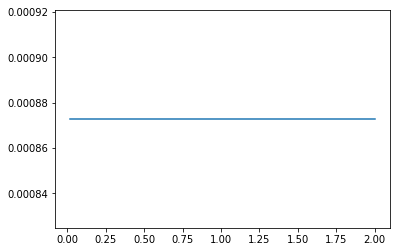

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0

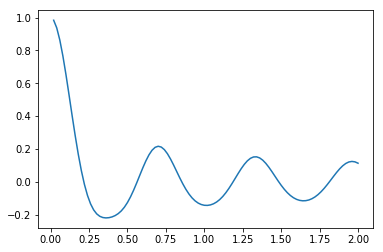

In [264]:
plt.plot(t,cos_repl)

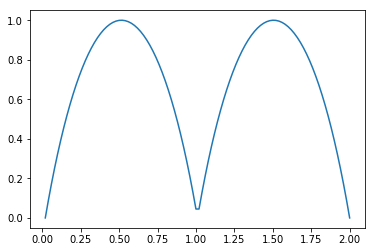

In [267]:
rho = TensorProduct(A,A)
rho = RotZZ*rho
rho = prod_op_to_hilbert(rho)
rho = lambdify(phi,rho)

theta = np.linspace(0,2*np.pi,100)
for k in range(100):
    ent[k] = logneg(rho(theta[k]))
plt.plot(t,ent)

In [256]:
GenRot = Matrix(genrott)
A = Matrix([1,0,0,1])
rho = TensorProduct(A,A)
rho = GenRot*rho
rho = prod_op_to_hilbert(rho)
rho = lambdify(theta,rho)
logneg(rho(0))

In [225]:
A = Matrix([np.cos(np.pi/3),0,0,1])
B = TensorProduct(A,A)
C = RotZZ*B
rho = prod_op_to_hilbert(C)
pptC = PPT(rho)
DD = lambdify(theta, pptC)

FF = lambdify(theta,rho)
GG = FF(np.pi/6)

In [226]:
n = 1000
x = np.linspace(0,360,n,endpoint=False)
xr = x/180*np.pi
y = np.zeros(n)
for i in range(n):
    y[i] = logneg(FF(xr[i]))
    

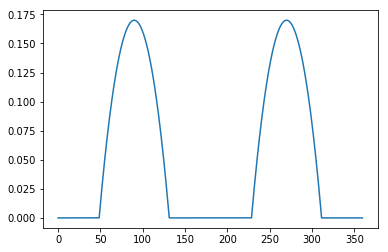

In [227]:
plt.plot(x,y)

In [177]:
np.linalg.norm(DD(0),'nuc')

In [113]:
if simplify(RotZZ[2,7]+sin(theta)):
    print(1)

In [101]:
A = Matrix([cos(theta),sin(theta),0,1])
B = TensorProduct(A,A)

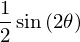

In [97]:
simplify(trace(prod_op_to_hilbert(B)*TensorProduct(sigma_x,sigma_y)))

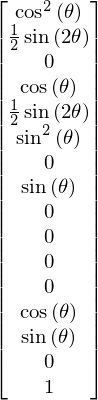

In [102]:
hilbert_to_prod_op(prod_op_to_hilbert(B))

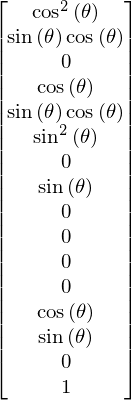

In [103]:
B

In [471]:
x = np.linspace(2,0,1000,endpoint=False)
y = fresnel(x)[0]

In [128]:
x

array([ 2.   ,  1.998,  1.996,  1.994,  1.992,  1.99 ,  1.988,  1.986,
        1.984,  1.982,  1.98 ,  1.978,  1.976,  1.974,  1.972,  1.97 ,
        1.968,  1.966,  1.964,  1.962,  1.96 ,  1.958,  1.956,  1.954,
        1.952,  1.95 ,  1.948,  1.946,  1.944,  1.942,  1.94 ,  1.938,
        1.936,  1.934,  1.932,  1.93 ,  1.928,  1.926,  1.924,  1.922,
        1.92 ,  1.918,  1.916,  1.914,  1.912,  1.91 ,  1.908,  1.906,
        1.904,  1.902,  1.9  ,  1.898,  1.896,  1.894,  1.892,  1.89 ,
        1.888,  1.886,  1.884,  1.882,  1.88 ,  1.878,  1.876,  1.874,
        1.872,  1.87 ,  1.868,  1.866,  1.864,  1.862,  1.86 ,  1.858,
        1.856,  1.854,  1.852,  1.85 ,  1.848,  1.846,  1.844,  1.842,
        1.84 ,  1.838,  1.836,  1.834,  1.832,  1.83 ,  1.828,  1.826,
        1.824,  1.822,  1.82 ,  1.818,  1.816,  1.814,  1.812,  1.81 ,
        1.808,  1.806,  1.804,  1.802,  1.8  ,  1.798,  1.796,  1.794,
        1.792,  1.79 ,  1.788,  1.786,  1.784,  1.782,  1.78 ,  1.778,
      

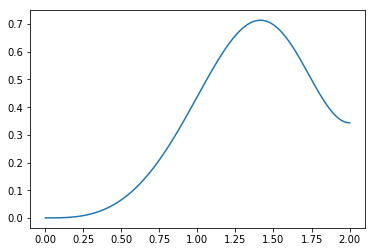

In [472]:
plt.plot(x,y)

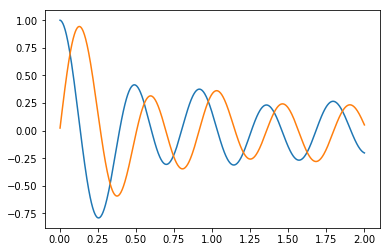

In [532]:
th1 = 0.4
th2 = 1.6
JJ=11
plt.plot(x,fr_repl(3.4,x,J=JJ,theta1=th1,theta2=th2)[0])
plt.plot(x,fr_repl(3.4,x,J=JJ,theta1=th1,theta2=th2)[1])